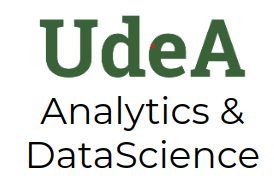

# Técnicas de clasificación para optimización de procesos de cargue de productos químicos

La operación de cargue de productos químicos, es un proceso con un alto componente de incertidumbre debido a la gran cantidad de elementos involucrados, y la posibilidad de que alguno de estos falle, así como la complejidad del proceso, que podría desencadenar un retraso logístico considerable en la operación. Dada la posibilidad de entender y describir adecuadamente el proceso a partir de la analítica, pueden brindarse herramientas valiosas a la compañía, con el propósito de tomar medidas correctivas a partir de un análisis mas profundo que el realizado actualmente con el uso de herramientas informáticas tradicionales.

## 1. Librerias y configuraciones previas

In [1]:
# Tratamiento de datos
# ==============================================================================
import pandas as pd
import numpy as np


# Matemáticas y estadísticas
# ==============================================================================
import math

# Preparación de datos
# ==============================================================================
from imblearn.over_sampling import RandomOverSampler
from sklearn.neighbors import LocalOutlierFactor

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

# Configuración matplotlib
# ==============================================================================
plt.rcParams['image.cmap'] = "bwr"
#plt.rcParams['figure.dpi'] = "100"
plt.rcParams['savefig.bbox'] = "tight"
style.use('ggplot') or plt.style.use('ggplot')

# Preparación de datos
# ==============================================================================
from sklearn.preprocessing import MinMaxScaler

# Evaluación de modelos
# ==============================================================================
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import ParameterGrid

import statsmodels.api as sm

from sklearn.svm import LinearSVC

from sklearn import svm

from sklearn.ensemble import RandomForestClassifier

from sklearn import metrics
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

## 2. Funciones

In [2]:
# Función para graficar un plot con multiples gráficas del mismo tipo:
#
# df       : dataframe 
# cols     : lista de columnas a graficar
# num_cols : número de columnas 
# num_rows : número de filas
# tipo     : 'c' = countplot,   'b' = boxplot, 's' = scatterplot 
# targetVar: nombre de la variable comparativa de salida. Debe ser numérica y debe estar cotenida en el dataframe. 
#            Para countplot no es necesario (None)
# figsize  : tamaño del plot. Valor por defecto (16,8)
#
# *Nota: el número de filas * el número de columnas debe ser mayor al total de elementos de cols
#
# Ejemplos:     
#    plot_multiples_graficas (d, catCols, 5, 3, 'c', None, (16,12))
#    plot_multiples_graficas (d, numCols, 5, 3, 's', 'price', (16,12))
#    plot_multiples_graficas (d, ['make'], 1, 1, 'b', 'price', (16,12))
# ==============================================================================


def plot_multiples_graficas(df, cols, num_cols, num_rows, tipo, targetVar, figsize=(16,8)):
    
    plt.rcParams['figure.figsize'] = figsize
    
    #num_plots = len(cols)
    #num_cols = math.ceil(np.sqrt(num_plots))
    #num_rows = math.ceil(num_plots/num_cols)
        
    fig, axs = plt.subplots(num_rows, num_cols)
     
    for ind, col in enumerate(cols):
        i = math.floor(ind/num_cols)
        j = ind - i*num_cols
        
        if num_rows == 1:
            if num_cols == 1:
                if tipo == 'c': 
                    sns.countplot(x=df[col], ax=axs, dodge = False)
                    axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=90)
                if tipo == 'b':
                    sns.boxplot(x=df[col], y=df[targetVar], ax=axs)
                if tipo == 's':
                    sns.scatterplot(x=df[col], y=df[targetVar], ax=axs)
            else:
                if tipo == 'c':
                    sns.countplot(x=df[col], ax=axs[j], dodge = False)
                if tipo == 'b':
                    sns.boxplot(x=df[col], y=df[targetVar], ax=axs[j])
                if tipo == 's':
                    sns.scatterplot(x=df[col], y=df[targetVar], ax=axs[j])
        else:
            if num_cols == 1: 
                if tipo == 'c':
                    sns.countplot(x=d[col], ax=axs[i], dodge = False)
                if tipo == 'b':
                    sns.boxplot(x=df[col], y=df[targetVar], ax=axs[i])
                if tipo == 's':
                    sns.scatterplot(x=df[col], y=df[targetVar], ax=axs[i])
            else:
                if tipo == 'c':
                    sns.countplot(x=df[col], ax=axs[i, j], dodge = False)
                if tipo == 'b':
                    sns.boxplot(x=df[col], y=df[targetVar], ax=axs[i, j])
                if tipo == 's':
                    sns.scatterplot(x=df[col], y=df[targetVar], ax=axs[i, j])

## 3. Carga del dataset

El data set corresponde a los tiempos de cargue de una Multinacional Colombiana, dedicada a la producción de cloruro de sodio y sus derivados químicos, por lo que la versión completa de la misma es de carácter confidencial y no se provee como anexo a este documento.

Para el segundo entregable de la materia "Seminario" del postgrado en analítica y ciencia de Datos, solo se usarán los datos correspondientes al año 2022 y el año 2023 hasta el 03 de marzo. Para las próximas iteraciones se realizará la limpieza y preparación de datos de 2020 y 2021, los cuales se encuentran en un formato diferente a los mencionados anteriormente

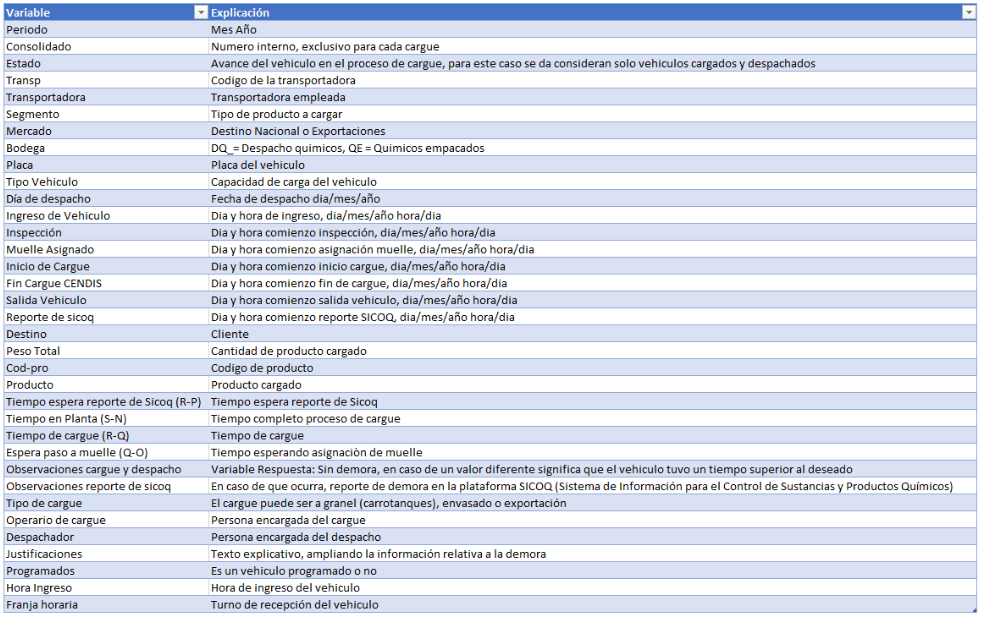



In [ ]:
data2022 = pd.read_excel ('Tiempos 2022 QM.xlsx')

In [ ]:
data2022.head()

In [ ]:
data2022.info()

In [ ]:
data2023 = pd.read_excel ('Tiempos 2023 QM.xlsx')

In [ ]:
data2023.head()

In [ ]:
data2023.info()

In [ ]:
data = pd.concat([data2022, data2023], axis=0)
data.reset_index(drop=True, inplace=True)

In [ ]:
data.info()

## 4. Limpieza de datos (Data Cleaning)

In [ ]:
#Borrando columnas que no se emplearán

# El Periodo puede ser eliminado, ya que se desea hacer una segmentación de acuerdo al dia de la semana
data.drop(['Periodo'], axis='columns', inplace=True)

# El Consolidado puede ser eliminado, ya que es un numero interno de seguimiento, que no aporta información al proceso
data.drop(['Consolidado'], axis='columns', inplace=True)

# Estado, avance del vehiculo en el proceso de cargue, para este caso todos los vehiculos han sido cargados y despachados
data.drop(['Estado'], axis='columns', inplace=True)

# Codigo de la transportadora, se conserva el nombre de la transportadora
data.drop(['Transp'], axis='columns', inplace=True)

# Segmento, variable que ya no es necesaria, ya que es rebundante con el producto
data.drop(['Segmento'], axis='columns', inplace=True)

# Se elimina tambien la variable Placa, que cuenta con 277 variables diferentes
data.drop(['Placa'], axis='columns', inplace=True)

# Día de despacho, variable que ya no es necesaria, esta información se toma de Ingreso de Vehiculo, segmentada por dia de ingreso
data.drop(['Día de despacho'], axis='columns', inplace=True)

# Como se desea construir un modelo que estime la posible de retraso en un cargue, esta alerta debe ir ligada al momento de
# llegada del vehiculo a planta, por lo que información obtenida con posterioridad no sera considerada.

# Se elimina Inspección, dato que se obtiene de manera posterior al ingreso de vehiculo
data.drop(['Inspección'], axis='columns', inplace=True)

# Se elimina Muelle Asignado, dato que se obtiene de manera posterior al ingreso de vehiculo
data.drop(['Muelle Asignado'], axis='columns', inplace=True)

# Se elimina Inicio de Cargue, dato que se obtiene de manera posterior al ingreso de vehiculo
data.drop(['Inicio de Cargue'], axis='columns', inplace=True)

# Se elimina Fin Cargue CENDIS, dato que se obtiene de manera posterior al ingreso de vehiculo
data.drop(['Fin Cargue CENDIS'], axis='columns', inplace=True)

# Se elimina Salida Vehiculo, dato que se obtiene de manera posterior al ingreso de vehiculo
data.drop(['Salida Vehiculo'], axis='columns', inplace=True)

# Reporte de sicoq, variable que solo aplica para una fracción de los productos cargados, dato que se obtiene de manera posterior al ingreso de vehiculo
data.drop(['Reporte de sicoq'], axis='columns', inplace=True)

# Destino, corresponde al cliente al que se hizo despacho, pero la operación a revisar esta limitada a la salida del vehiculo
# de planta, por lo que puede ser eliminada
data.drop(['Destino'], axis='columns', inplace=True)

# Codigo del producto cargado
data.drop(['Cod-pro'], axis='columns', inplace=True)

# Tiempo espera reporte de Sicoq (R-P), variable tipo objeto, dato que se obtiene de manera posterior al ingreso de vehiculo
data.drop(['Tiempo espera reporte de Sicoq (R-P)'], axis='columns', inplace=True)

# Tiempo en Planta (S-N), variable tipo objeto, que puede ser calculada a partir de las otras variables
# datetime que componen el dataset
data.drop(['Tiempo en Planta (S-N)'], axis='columns', inplace=True)

# Tiempo de cargue (R-Q), variable tipo objeto, que puede ser calculada a partir de las otras variables
# datetime que componen el dataset
data.drop(['Tiempo de cargue (R-Q)'], axis='columns', inplace=True)

# Espera paso a muelle (Q-O), variable tipo objeto, que puede ser calculada a partir de las otras variables
# datetime que componen el dataset
data.drop(['Espera paso a muelle (Q-O)'], axis='columns', inplace=True)

# Observaciones para el caso de demoras en el reporte SICOQ
data.drop(['Observaciones reporte de sicoq'], axis='columns', inplace=True)

# PROGRAMADOS, variable introducida recientemente pero que solo cubre una pequeña fracción de los datos, 
# ademas de que los parametros para programación estan en un proceso de revisión
data.drop(['PROGRAMADOS '], axis='columns', inplace=True)

# HORA INGRESO, variable introducida recientemente pero que solo cubre una pequeña fracción de los datos,
# ademas de que puede deducirse de la variable "Ingreso de Vehiculo"
data.drop(['HORA INGRESO'], axis='columns', inplace=True)

# FRANJA HORARIA, variable introducida recientemente pero que solo cubre una pequeña fracción de los datos,
# ademas de que puede deducirse de la variable "Ingreso de Vehiculo"
data.drop(['FRANJA HORARIA'], axis='columns', inplace=True)

# Justificaciones, variable de texto abierta
data.drop(['Justificaciones'], axis='columns', inplace=True)

#Variables sin información
data = data.drop(['Unnamed: 35', 'Unnamed: 36', 'Unnamed: 37', 'Unnamed: 38', 'Unnamed: 39', 'Unnamed: 40', 'Unnamed: 41', 'Unnamed: 42'], axis=1)

# Justificaciones sicoq, variable que solo aplica para una fracción de los productos cargados, 
data.drop(['Justificaciones sicoq'], axis='columns', inplace=True)

In [ ]:
data.info()

In [ ]:
data.head()

In [ ]:
# eliminación de registros duplicados
data=data.drop_duplicates()

# eliminación de nulos
data = data.dropna()

#Reiniciar el indice
data.reset_index(drop=True, inplace=True) 

In [ ]:
data.info()

In [ ]:
for col in data.columns:
    print("="*5 + f" {col} " + "="*20)
    print(data[col].value_counts())
    print()

In [ ]:
# Se conservan los valores diferentes de "SIN DEFINIR" de la variable "Tipo vehiculo" de la base de datos

data = data[data['Tipo Vehiculo']!='SIN DEFINIR']

# Se eliminan los valores errados de la variable "Tipo cargue" de base de datos

data = data[data['Tipo de cargue']!='TIEMPO DE ALMUERSO/CENA']
data = data[data['Tipo de cargue']!='TDZ592']
data = data[data['Tipo de cargue']!='LPZ021']
data = data[data['Tipo de cargue']!='VCN721']


In [ ]:
for col in data.columns:
    print("="*5 + f" {col} " + "="*20)
    print(data[col].value_counts())
    print()

## 5. Generación nuevas variables de entrada

In [ ]:
data['hora entrada'] = data['Ingreso de Vehiculo'].dt.hour

data['Dia semana'] = data['Ingreso de Vehiculo'].dt.strftime('%A')

# Justificaciones, variable de texto abierta
data.drop(['Ingreso de Vehiculo'], axis='columns', inplace=True)

In [ ]:
data.info()

## 6. Transformación variable de salida

Se construyo la variable categorica respuesta, que indica si un vehiculo presento o no demora en el cargue, de acuerdo a las metas indicadas por la compañia

Siendo 1 = Cargue dentro del tiempo deseado, 0 = Cargue con algun tipo de demora

In [ ]:
# Aplicación de la función de get_dummies

d =pd.get_dummies(data['Observaciones cargue y despacho'], drop_first=0)

In [ ]:
d.info()

In [ ]:
d.columns.values[15] = 'DEMORA CARGUE'

In [ ]:
data = pd.concat([data, d.iloc[:, 15]], axis=1)

data.reset_index(drop=True, inplace=True)

In [ ]:
# Observaciones para el caso de demoras en el reporte SICOQ
data.drop(['Observaciones cargue y despacho'], axis='columns', inplace=True)


In [ ]:
data.info()

In [ ]:
for col in data.columns:
    print("="*5 + f" {col} " + "="*20)
    print(data[col].value_counts())
    print()

## 7. Visualización de datos

### Variables de entrada

In [ ]:
#Lista de variables categóricas
catCols = data.select_dtypes(include = ["object", 'category']).columns.tolist()

data[catCols].head()

In [ ]:
#Lista de variables numéricas

numCols=data.select_dtypes(include = ['float64','int32','int64']).columns.tolist()
data[numCols].head()

In [ ]:
#Visualización de frecuencia de instancias para variables categóricas
plot_multiples_graficas(data,catCols, 3, 3, 'c', None, (48,18))

In [ ]:
#Visualización de frecuencia de instancias para variables categóricas
plot_multiples_graficas(data,['hora entrada', 'Peso Total'], 2, 1, 'c', None, (32,9))

### Variables de salida

In [ ]:
# Distriución de la variable de salida

print("="*5 + f" {col} " + "="*20)
print(data['DEMORA CARGUE'].value_counts())

## 8. Preparación de datos

Se hace verificación de presencia de nulos dentro del Dataset

In [ ]:
# Identificación de valores nulos para las variables numéricas
for col in data[numCols]:
    print (col, np.sum(pd.isnull(data[col])))

In [ ]:
# Identificación de valores nulos para las variables categóricas
for col in data[catCols]:
    print (col, np.sum(pd.isnull(data[col])))

### Valores atípicos para las variables de entrada

In [ ]:
#utilización de LocalOutlierFactor con 11 vecinos para identificar valores atípicos en las variables de entrada


# crear un objeto LocalOutlierFactor con n_neighbors=11
lof = LocalOutlierFactor(n_neighbors=11, contamination=0.05)

# identificar los valires atípicos por medio de lof 
y_pred = lof.fit_predict(data[numCols])

# Identificar los índices de los valores atípicos
outliers = y_pred == -1

print('Indices de valores atípicos: ', data[outliers].index.tolist())

In [ ]:
# Eliminar los valores atípicos del dataframe original
data = data.loc[~outliers]

### Transformaciones

In [ ]:
for col in data.columns:
    print("="*5 + f" {col} " + "="*20)
    print(data[col].value_counts())
    print()

In [ ]:
# Se crea una nueva categoria para las otras transportadoras

data = data.replace({'VLIMAR': 'OTRA TRANSPORTADORA',
                    'TRANSPORTE DIRECTO': 'OTRA TRANSPORTADORA', 
                    'COLTANQUES': 'OTRA TRANSPORTADORA',
                    'INANTRA': 'OTRA TRANSPORTADORA',
                    'ADISPETROL': 'OTRA TRANSPORTADORA'})

In [ ]:
# Se unifican los productos cargados en granel, tambor, garrafa o IBC

data = data.replace({'PISCICLOR GARRAFA X 20 lt': 'GARRAFA',
                    'ACIDO CLORHIDRICO AL33%TBX55GL': 'TAMBOR', 
                    'AGROCLOR GARRAFA X 20 lt': 'GARRAFA', 
                    'HIPOCLORITO AL 15% TBX55G.(KG)': 'TAMBOR',
                    'SODA CAUSTICA 20L': 'GARRAFA',
                    'HIPOCLORITO IBC': 'IBC',
                    'LABSA POR IBC': 'IBC',
                    'LABSA BRENNTAG TAMBOR X 215 Kg': 'TAMBOR',
                    'LABSA TAMBOR ME CLIENTE X 215 KG': 'TAMBOR',
                    'ACIDO CLORHIDRICO AL33%X1000lt': 'IBC',
                    'LABSA A GRANEL MAQUILAS': 'LABSA GRANEL',
                    ' LABSA DISAN TAMBOR X 215 KG': 'TAMBOR',
                    'ACIDO CLORHIDRICO AL33%TBX55GL': 'TAMBOR',
                    'PISCICLOR HIPOCLORITO 15% X20': 'GARRAFA',
                    'SODA CAUSTICA 1000 L': 'IBC',
                    'LABSA GARRAFA': 'GARRAFA',
                    'HIPOCLORITO AL 13% X 20 lt': 'GARRAFA'})

In [ ]:
# Se agrupan los Operarios de cargue

data['Operario de cargue'] = data['Operario de cargue'].replace({'DIEGO CASTAÑEDA': 'OTRO OPERARIO',
                                                                'JEISSON PARDO': 'OTRO OPERARIO', 
                                                                'CRISTIAN VARGAS': 'OTRO OPERARIO', 
                                                                'EDGAR FORERO': 'OTRO OPERARIO',
                                                                'CARLOS CASTILLO': 'OTRO OPERARIO',
                                                                'YEISON PARDO': 'OTRO OPERARIO',
                                                                'MARCOS GRANDE': 'OTRO OPERARIO',
                                                                'JORGE ALDANA': 'OTRO OPERARIO',
                                                                'EFORERO': 'OTRO OPERARIO'})

In [ ]:
# Se agrupan los Despachadores

data['Despachador'] = data['Despachador'].replace({'OSCAR PACHON': 'OTRO DESPACHADOR',
                                                    'MARCOS GRANDE': 'OTRO DESPACHADOR',
                                                    'MIGUEL MORENO': 'OTRO DESPACHADOR',
                                                    'CACASTILLO': 'CARLOS CASTILLO',
                                                    'EFORERO': 'EDGAR FORERO'})

In [ ]:
for col in data.columns:
    print("="*5 + f" {col} " + "="*20)
    print(data[col].value_counts())
    print()

### Sobremuestreo (oversampling)

In [ ]:
# Se crea un objeto RandomOverSampler que permite crear copias aleatorias de las muestras de la clase 
# minoritaria para igualar el número de muestras entre las diferentes clases.
oversampler = RandomOverSampler()

# Se realiza el sobremuestreo para las variables de entrada y salida
X_resampled, y_resampled = oversampler.fit_resample(data.drop('DEMORA CARGUE', axis=1), data['DEMORA CARGUE'])

# Se crean dos dataframes con las variables de entrada y otro con la variable de salida a partir del proceso anterior
df1 = pd.DataFrame(X_resampled, columns=data.columns.drop('DEMORA CARGUE'))
df2 = pd.DataFrame(y_resampled)

# Se concatenan los dataframes horizontalmente
d = pd.concat([df1, df2], axis=1)

In [ ]:
# Dataset balanceado
d.head()

In [ ]:
# Distriución de la variable de salida, ya balanceada

print("="*5 + f" {col} " + "="*20)
print(d['DEMORA CARGUE'].value_counts())

## 9. Prueba dataset: Creación de un modelo

In [ ]:
# Aplicación de la función de get_dummies

d =pd.get_dummies(d, drop_first=1)

In [ ]:
d.info()

## 10. Creación del modelo

### Dividir el conjunto de datos

In [ ]:
#Se establece las variables de entrada 'X' y la variable de salida 'y'
X = d.drop(columns ='DEMORA CARGUE')
y = d['DEMORA CARGUE']

In [ ]:
# Se crean los datasets de entrenamiento y prueba para las variables de entrada y salida 

X_train, X_test, y_train, y_test = train_test_split(
                                        X,
                                        y.values.reshape(-1,1), 
                                        train_size   = 0.8,
                                        random_state = 123,
                                        shuffle      = True
                                    )

### Escalar Variables

In [ ]:
#Se establecen las variables numéricas a escalar

#Num_vars se le asigna la lista con las variables numerivas para posteriormente escalarlas
num_vars = numCols

print(num_vars)

In [ ]:
#Escalar Variables númericas

pd.set_option('display.float_format', lambda x: '%.4f' % x)

# Se crea un objeto MinMaxScaler
scaler = MinMaxScaler()

# Se escalan los valores del dataset entrenamiento y prueba de las columnas numéricas
X_train[num_vars] = scaler.fit_transform(X_train[num_vars])
X_test[num_vars] = scaler.fit_transform(X_test[num_vars])

X_train[num_vars].head()

## 11. SVM

#### 11.1. Lineal y método de retención (*holdout method*)

##### Creación y entrenamiento del modelo

In [ ]:
#Creación del modelo 

modelSVC = svm.SVC(kernel='linear')

#Entrenamiento del modelo con 80% de training
modelSVC.fit(X_train, y_train)

In [ ]:
y_pred = modelSVC.predict(X_test)

##### Evaluación del modelo

In [ ]:
# Crear matriz de confusión
conf_mat = confusion_matrix(y_test, y_pred)

# Crear figura y ejes
fig, ax = plt.subplots(figsize=(6,4))

# Crear mapa de calor de la matriz de confusión con Seaborn
sns.heatmap(conf_mat
            , annot=True  # agregar valores en cada celda
            , fmt='d'    # formato de los valores (d = decimal)
           )

# Agregar etiquetas a los ejes x e y
plt.ylabel('Actual')
plt.xlabel('Predicted')

# Mostrar la figura
plt.show()

# Se imprimen las medidas de rendimiento del modelo
print(metrics.classification_report(y_test, y_pred))

In [ ]:
#f1-Score
print("f1-score:",metrics.f1_score(y_test, y_pred))

#### 11.2. Lineal y validación cruzada (*Cross validation*)

##### Creación y entrenamiento del modelo

In [ ]:
#Se establece las variables de entrada 'X' y la variable de salida 'y'

X = d.drop(columns ='DEMORA CARGUE')
y = d['DEMORA CARGUE']

# la validación cruzada se realiza sobre todo el dataset
X_Completo = X
y_Completo = y

In [ ]:
#Se establecen las variables numéricas a escalar

#Num_vars se le asigna la lista con las variables numerivas para posteriormente escalarlas
num_vars = numCols

# Se crea un objeto MinMaxScaler
scaler = MinMaxScaler()

# Se escalan los valores del dataset entrenamiento y prueba de las columnas numéricas
X_Completo[num_vars] = scaler.fit_transform(X_Completo[num_vars])

X_Completo[num_vars].head()

In [ ]:
CV = 10 #Folks:  Pliegues
scoring = 'f1'


entries = []
accuracies = cross_val_score(modelSVC, X_Completo, y_Completo, cv=CV, scoring=scoring)

for fold_idx, accuracy in enumerate(accuracies):
    entries.append(( fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['fold_idx', 'f1-Score'])

#### Evaluación del modelo

In [ ]:
print(cv_df)
print('f1-score:', cv_df['f1-Score'].mean())

## 12. Afinando el modelo SVM (tuning)

Entre sus parámetros, encontramos:

- C: parámetro de regularización.
- kernel: especifica el tipo de kernel usado por el algoritmo (lineal, polinómico, radial, etc.).
- degree: grado de la función con kernel polinómico.
- gamma: coeficiente del kernel para ‘rbf’, ‘poly’ y ‘sigmoid’.
- probability: indica si se permite la estimación de probabilidades.
- max_iter: límite de iteraciones.
- decision_function_shape: permite establecer el método one-vs-one o one-vs-all.
- random_state: semilla para el generador de número pseudoaleatorios.

El parámetro "C" es el inverso del parámetro λ de regularización por lo cual, si tenemos un valor alto de nuestro parámetro tendremos una mayor varianza y la regularización será menor, mientras que por el contrario, si tenemos un valor bajo, tendremos un mayor efecto de la regularización. Ver: https://dzone.com/articles/support-vector-machines-tutorial

#### 12.1. Lineal e hiperparámetro *C*  (con validación cruzada - *Cross validation*

##### Identificacion del mejor hiperparametro *C*

In [ ]:
#1 Creacion del modelo
svmL = svm.SVC(kernel='linear', random_state = 0)

# Establecemos un grid con los valores de coste que queremos evaluar
grid_hiperparametros = {'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]} 

# definicion de la variable con el número de pliegues
CV = 10

# las metricas sobre las se evaluará el modelo
metricas = 'f1'

# Definimos la busqueda mediante 10-fold CV
busqueda_grid = GridSearchCV(estimator = svmL
                             , param_grid = grid_hiperparametros 
                             , cv = CV
                             , scoring = metricas
                             , return_train_score = True
                             , verbose=4
                             , n_jobs=-1)


# Aplicamos la busqueda
busqueda_grid.fit(X_Completo, y_Completo)

#busqueda_grid.cv_results_.keys()

In [ ]:
#2 Almacenamos en variables los resultados de la busqueda grid
C_cv = busqueda_grid.cv_results_['param_C'].tolist()

f1_medio_cv = busqueda_grid.cv_results_['mean_test_score'].tolist()
f1_std_cv   = busqueda_grid.cv_results_['std_test_score'].tolist()

In [ ]:
#3 Generamos un data frame con los resultados de la validacion cruzada
df_resultados_cv = pd.DataFrame({'C': C_cv, 
                                 'mean_test_f1-score': f1_medio_cv,
                                 'std_test_f1-score': f1_std_cv})

print(df_resultados_cv)

# Mejores hiperparametros sobre los datos hold-out
print('Valor de coste y grado óptimos:', busqueda_grid.best_params_)

##### Creación y entrenamiento del modelo

In [ ]:
#4 Ajustamos el modelo SVM lineal usando el valor de coste óptimo obtenido en cv
modelo_svmL = svm.SVC(kernel='linear', 
                      C = busqueda_grid.best_params_.get('C'), #C=0.001
                      random_state = 0) # semilla

In [ ]:
#5
CV = 10 #Folks:  Pliegues
scoring = 'f1' 

entries = []
accuracies = cross_val_score(modelo_svmL, X_Completo, y_Completo,cv=CV, scoring=scoring)

for fold_idx, accuracy in enumerate(accuracies):
    entries.append(( fold_idx, accuracy))
cv_dfl = pd.DataFrame(entries, columns=['fold_idx', 'f1-Score'])

#### Evaluación del modelo

In [ ]:
#6
print(cv_dfl)
print('f1-Score:', cv_dfl['f1-Score'].mean())

#### 12.2. Polinómico e hiperparámetros: *C* y *degree*  (con validación cruzada  - *Cross validation*)

##### Identificación del mejor hiperparametro *C* y *degree*

In [ ]:
#1 Creacion del modelo
svmP = svm.SVC(kernel='poly', random_state = 0)

# Establecemos un grid con los valores de coste que queremos evaluar
grid_hiperparametros = {'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                        'degree': [2, 3]} 

# definicion de la variable con el número de pliegues
CV = 10

# las metricas sobre las se evaluará el modelo
metricas = 'f1'

# Definimos la busqueda mediante 10-fold CV
busqueda_grid = GridSearchCV(estimator = svmP 
                             , param_grid = grid_hiperparametros 
                             , cv = CV
                             , scoring = metricas
                             , return_train_score = True
                             , verbose=4
                             , n_jobs=-1)


# Aplicamos la busqueda
busqueda_grid.fit(X_Completo, y_Completo)

In [ ]:
#2 Almacenamos en variables los resultados de la busqueda grid
C_cv = busqueda_grid.cv_results_['param_C'].tolist()
degree_cv = busqueda_grid.cv_results_['param_degree'].tolist()

f1_medio_cv = busqueda_grid.cv_results_['mean_test_score'].tolist()
f1_std_cv = busqueda_grid.cv_results_['std_test_score'].tolist()

In [ ]:
#3 Generamos un data frame con los resultados de la validacion cruzada
df_resultados_cv = pd.DataFrame({'C': C_cv, 
                                 'degree': degree_cv, 
                                 'mean_test_f1-score': f1_medio_cv,
                                 'std_test_f1-score': f1_std_cv})
                                 
print(df_resultados_cv)

# Mejores hiperparametros sobre los datos hold-out
print('Valor de coste y grado óptimos:', busqueda_grid.best_params_)

#### Creación y entrenamiento del modelo

In [ ]:
#4 Ajustamos el modelo SVM lineal usando el valor de coste óptimo obtenido en cv
modelo_svmP = svm.SVC(kernel = 'poly', 
                      C = busqueda_grid.best_params_.get('C'), #C=0.1
                      degree = busqueda_grid.best_params_.get('degree'), #degree=2
                      random_state = 0) # semilla

In [ ]:
#5
CV = 10 #Folks:  Pliegues
scoring = 'f1' 


entries = []
accuracies = cross_val_score(modelo_svmP, X_Completo, y_Completo, cv=CV, scoring=scoring)

for fold_idx, accuracy in enumerate(accuracies):
    entries.append(( fold_idx, accuracy))
cv_dfP = pd.DataFrame(entries, columns=['fold_idx', 'f1-Score'])

#### Evaluación del modelo

In [ ]:
#6
print(cv_dfP)
print('f1-score', cv_dfP['f1-Score'].mean())

#### 12.3. Radial e hiperparámetros: *C* y *gamma*  (con validación cruzada  - *Cross validation*)

##### Identificación del mejor hiperparametro *C* y *gamma*

In [ ]:
#1 Creacion del modelo
svmR = svm.SVC(kernel='rbf', random_state = 0)



# Establecemos un grid con los valores de coste que queremos evaluar
grid_hiperparametros = {'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                        'gamma': [0.001, 0.01, 0.1, 1, 3, 5]} 
                        
# definicion de la variable con el número de pliegues
CV = 10

# Definimos las metricas sobre las que queremos evaluar
metricas = 'f1'

# Definimos la busqueda mediante 10-fold CV
busqueda_grid = GridSearchCV(estimator = svmR
                             , param_grid = grid_hiperparametros 
                             , cv = CV
                             , scoring = metricas
                             , return_train_score = True
                             , verbose=4
                             , n_jobs=-1)


# Aplicamos la busqueda
busqueda_grid.fit(X_Completo, y_Completo)

In [ ]:
#2 Almacenamos en variables los resultados de la busqueda grid
C_cv = busqueda_grid.cv_results_['param_C'].tolist()
gamma_cv = busqueda_grid.cv_results_['param_gamma'].tolist()

f1_medio_cv = busqueda_grid.cv_results_['mean_test_score'].tolist()
f1_std_cv = busqueda_grid.cv_results_['std_test_score'].tolist()

In [ ]:
#3 Generamos un data frame con los resultados de la validacion cruzada
df_resultados_cv = pd.DataFrame({'C': C_cv, 
                                 'gamma': gamma_cv, 
                                 'mean_test_f1-score': f1_medio_cv,
                                 'std_test_f1-score': f1_std_cv})
                                 
print(df_resultados_cv)

# Mejores hiperparametros sobre los datos hold-out
print('Valor de coste y gamma óptimos:', busqueda_grid.best_params_)

##### Creación y entrenamiento del modelo

In [ ]:
#4 Ajustamos el modelo SVM lineal usando el valor de coste óptimo obtenido en cv
modelo_svmR = svm.SVC(kernel = 'rbf', 
                      C = busqueda_grid.best_params_.get('C'), #C=0.1
                      gamma = busqueda_grid.best_params_.get('gamma'), #gamma=0.01
                      random_state = 0) # semilla  

In [ ]:
#5
CV = 10 #Folks:  Pliegues
scoring = 'f1' 


entries = []
accuracies = cross_val_score(modelo_svmR, X_Completo, y_Completo, cv=CV, scoring=scoring)

for fold_idx, accuracy in enumerate(accuracies):
    entries.append(( fold_idx, accuracy))
cv_dfR = pd.DataFrame(entries, columns=['fold_idx', 'f1-Score'])

#### Evaluación del modelo

In [ ]:
#6
print(cv_dfR)
print('f1-score', cv_dfR['f1-Score'].mean())

#### 12.4. Sigmoide e hiperparámetros: *C* y *gamma*  (con validación cruzada  - *Cross validation*)

##### Identificación del mejor hiperparametro *C* y *gamma*

In [ ]:
#1 Creacion del modelo
svmS = svm.SVC(kernel='sigmoid', random_state = 0)


# Establecemos un grid con los valores de coste que queremos evaluar
grid_hiperparametros = {'C': [0.0001, 0.001, 0.01, 0.1, 10, 100],
                        'gamma': [0.001, 0.01, 0.1, 1, 3, 5]} 
                        
# definicion de la variable con el número de pliegues
CV = 10

# Definimos las metricas sobre las que queremos evaluar
metricas = 'f1'

# Definimos la busqueda mediante 10-fold CV
busqueda_grid = GridSearchCV(estimator = svmS
                             , param_grid = grid_hiperparametros 
                             , cv = CV
                             , scoring = metricas
                             , return_train_score = True
                             , verbose=4
                             , n_jobs=-1)


# Aplicamos la busqueda
busqueda_grid.fit(X_Completo, y_Completo)

##### Identificación del mejor hiperparametro *C* y *gamma*

In [ ]:
#2 Almacenamos en variables los resultados de la busqueda grid
C_cv = busqueda_grid.cv_results_['param_C'].tolist()
gamma_cv = busqueda_grid.cv_results_['param_gamma'].tolist()

f1_medio_cv = busqueda_grid.cv_results_['mean_test_score'].tolist()
f1_std_cv = busqueda_grid.cv_results_['std_test_score'].tolist()

In [ ]:
#3 Generamos un data frame con los resultados de la validacion cruzada
df_resultados_cv = pd.DataFrame({'C': C_cv, 
                                 'gamma': gamma_cv, 
                                 'mean_test_f1-score': f1_medio_cv,
                                 'std_test_f1-score': f1_std_cv})
                                 
print(df_resultados_cv)

# Mejores hiperparametros sobre los datos hold-out
print('Valor de coste y gamma óptimos:', busqueda_grid.best_params_)

##### Creación y entrenamiento del modelo

In [ ]:
#4 Ajustamos el modelo SVM sigmoide usando el valor de coste óptimo obtenido en cv
modelo_svmS = svm.SVC(kernel = 'sigmoid', 
                      C = busqueda_grid.best_params_.get('C'), #C=0.1
                      gamma = busqueda_grid.best_params_.get('gamma'), #gamma=0.1
                      random_state = 0,
                        probability=True) # semilla 

In [ ]:
#5
CV = 10 #Folks:  Pliegues
scoring = 'f1' 


entries = []
accuracies = cross_val_score(modelo_svmS, X_Completo, y_Completo, cv=CV, scoring=scoring)

for fold_idx, accuracy in enumerate(accuracies):
    entries.append(( fold_idx, accuracy))
cv_dfS = pd.DataFrame(entries, columns=['fold_idx', 'f1-Score'])

#### Evaluación del modelo

In [ ]:
#6
print(cv_dfS)
print('f1-score', cv_dfS['f1-Score'].mean())

### 13. Eligiendo el modelo SVM

In [ ]:
print('f1-Score')
print('==================================================================')
print('Lineal                                  :', cv_df['f1-Score'].mean().round(4))
print('Lineal e hiperparámetro C               :', cv_dfl['f1-Score'].mean().round(4))
print('Polinómico e hiperparámetros: C y degree:', cv_dfP['f1-Score'].mean().round(4))
print('Radial e hiperparámetros: C y gamma     :', cv_dfR['f1-Score'].mean().round(4))
print('Sigmoide e hiperparámetros: C y gamma   :', cv_dfS['f1-Score'].mean().round(4))

In [ ]:
#Entrenamiento modelo SVM Radial
modelo_svmR.fit(X_train, y_train)
y_pred = modelo_svmR.predict(X_test)

In [ ]:
# Crear matriz de confusión
conf_mat = confusion_matrix(y_test, y_pred)

# Crear figura y ejes
fig, ax = plt.subplots(figsize=(6,4))

# Crear mapa de calor de la matriz de confusión con Seaborn
sns.heatmap(conf_mat
            , annot=True  # agregar valores en cada celda
            , fmt='d'    # formato de los valores (d = decimal)
           )

# Agregar etiquetas a los ejes x e y
plt.ylabel('Actual')
plt.xlabel('Predicted')

# Mostrar la figura
plt.show()

# Se imprimen las medidas de rendimiento del modelo
print(metrics.classification_report(y_test, y_pred))

In [ ]:
#Entrenamiento modelo SVM Sigmoide
modelo_svmS.fit(X_train, y_train)
y_pred = modelo_svmS.predict(X_test)

In [ ]:
# Crear matriz de confusión
conf_mat = confusion_matrix(y_test, y_pred)

# Crear figura y ejes
fig, ax = plt.subplots(figsize=(6,4))

# Crear mapa de calor de la matriz de confusión con Seaborn
sns.heatmap(conf_mat
            , annot=True  # agregar valores en cada celda
            , fmt='d'    # formato de los valores (d = decimal)
           )

# Agregar etiquetas a los ejes x e y
plt.ylabel('Actual')
plt.xlabel('Predicted')

# Mostrar la figura
plt.show()

# Se imprimen las medidas de rendimiento del modelo
print(metrics.classification_report(y_test, y_pred))

In [ ]:
# Predecir las etiquetas de clase usando el modelo de regresión logística entrenado
predicted_labels = modelo_svmR.predict(X_test)

# Calcular el área bajo la curva ROC
auc = roc_auc_score(y_test, predicted_labels)

# Imprimir el valor del AUC
print('AUC: %.2f' % auc)

# Calcular la curva ROC usando los valores verdaderos y las etiquetas predichas
fpr, tpr, thresholds = roc_curve(y_test, predicted_labels)

# Graficar la curva ROC
plot_roc_curve(fpr, tpr)

## 13. Random Forest

### 13.1 Grid Search basado en out-of-bag score

In [ ]:
# Grid de hiperparámetros evaluados

# oob_score = bootstrap
# ==============================================================================
param_grid = ParameterGrid(
                {'n_estimators': [150],
                 'max_features': [5, 7, 9],
                 'max_depth'   : [None, 3, 10, 20],
                 'criterion'   : ['gini', 'entropy']
                }
            )

# Loop para ajustar un modelo con cada combinación de hiperparámetros
# ==============================================================================
resultados = {'params': [], 'oob_accuracy': []}

for params in param_grid:
    
    
    modelo = RandomForestClassifier(
                oob_score    = True,
                n_jobs       = -1,
                random_state = 123,
                ** params
             )
    
    modelo.fit(X_train, y_train)
    
    
    resultados['params'].append(params)
    resultados['oob_accuracy'].append(modelo.oob_score_)
    print(f"Modelo: {params} \u2713")

# Resultados
# ==============================================================================
resultados = pd.DataFrame(resultados)
resultados = pd.concat([resultados, resultados['params'].apply(pd.Series)], axis=1)
resultados = resultados.sort_values('oob_accuracy', ascending=False)
resultados = resultados.drop(columns = 'params')

In [ ]:
resultados.head()

### 13.2 Grid Search basado en validación cruzada

In [ ]:
# Grid de hiperparámetros evaluados
# ==============================================================================
param_grid = {'n_estimators': [150],
              'max_features': [5, 7, 9],
              'max_depth'   : [None, 3, 10, 20],
              'criterion'   : ['gini', 'entropy']
             }

# Búsqueda por grid search con validación cruzada
# ==============================================================================
grid = GridSearchCV(
        estimator  = RandomForestClassifier(random_state = 123),
        param_grid = param_grid,
        scoring    = 'accuracy',
        n_jobs     = - 1,
        refit      = True,
        verbose    = 0,
        return_train_score = True
       )

grid.fit(X = X_train, y = y_train)

# Resultados
# ==============================================================================
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param*|mean_t|std_t)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False) \
    .head(4)

In [ ]:
# Mejores hiperparámetros por validación cruzada
# ==============================================================================
print("----------------------------------------")
print("Mejores hiperparámetros encontrados (cv)")
print("----------------------------------------")
print(grid.best_params_, ":", grid.best_score_, grid.scoring)

In [ ]:
modelo_final = grid.best_estimator_

In [ ]:
modelo_final

In [ ]:
# Error de test del modelo final
# ==============================================================================
y_pred = modelo_final.predict(X_test)

#### Evaluación del modelo

In [ ]:
# Crear matriz de confusión
conf_mat = confusion_matrix(y_test, y_pred)

# Crear figura y ejes
fig, ax = plt.subplots(figsize=(6,4))

# Crear mapa de calor de la matriz de confusión con Seaborn
sns.heatmap(conf_mat
            , annot=True  # agregar valores en cada celda
            , fmt='d'    # formato de los valores (d = decimal)
           )

# Agregar etiquetas a los ejes x e y
plt.ylabel('Actual')
plt.xlabel('Predicted')

# Mostrar la figura
plt.show()

# Se imprimen las medidas de rendimiento del modelo
print(metrics.classification_report(y_test, y_pred))

In [ ]:
# Predecir las etiquetas de clase usando el modelo de regresión logística entrenado
predicted_labels = modelo_final.predict(X_test)

# Calcular el área bajo la curva ROC
auc = roc_auc_score(y_test, predicted_labels)

# Imprimir el valor del AUC
print('AUC: %.2f' % auc)

# Calcular la curva ROC usando los valores verdaderos y las etiquetas predichas
fpr, tpr, thresholds = roc_curve(y_test, predicted_labels)

# Graficar la curva ROC
plot_roc_curve(fpr, tpr)